<a href="https://colab.research.google.com/github/schen304joseph/HW3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

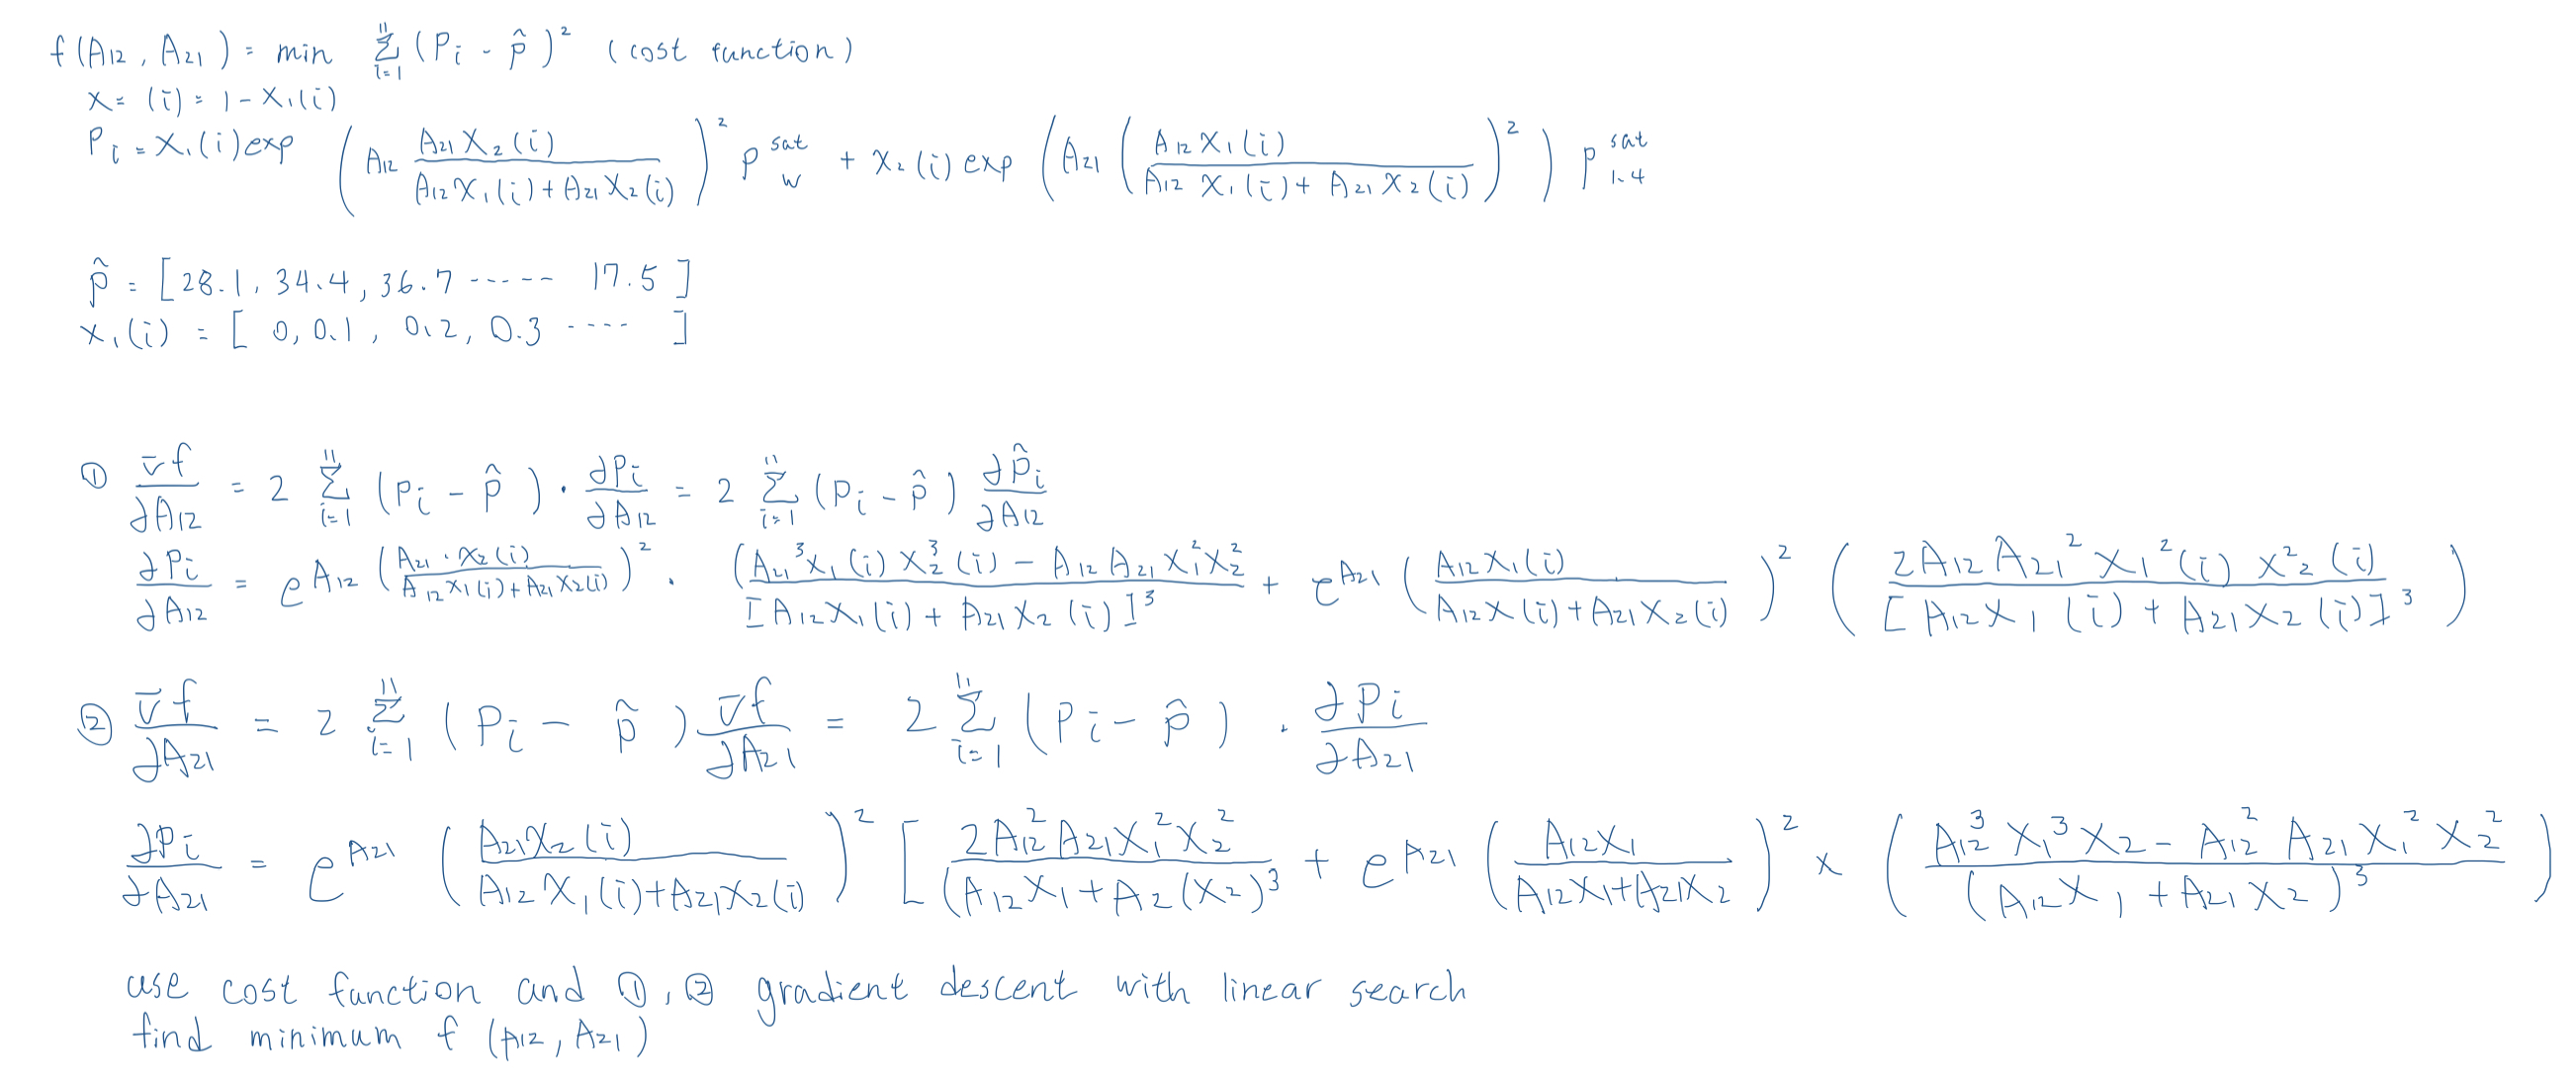

A12= 1.95841966952408
A21= 1.6891850023576693


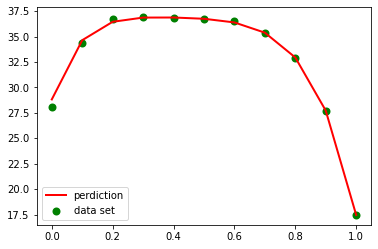

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

x1 = np.arange(start=0, stop=1.1, step=0.1)
p = np.array([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5])

def psat (a1,a2,a3):
  return 10**(a1-(a2/(20+a3)))

def pval (x1,A12,A21):
  x2 = 1-x1
  return x1*np.exp(A12*((A21*x2)/(A12*x1+A21*x2))**2)*psat(8.07131,1730.63,233.426)+x2*np.exp(A21*((A12*x1)/(A12*x1+A21*x2))**2)*psat(7.43155,1554.679,240.337)

c, cov = curve_fit(pval,x1,p)

n = len(x1)
y=np.empty(n)
for i in range(n):
  y[i]=pval(x1[i],c[0],c[1])

plt.scatter(x1,p,color="green",label="data set",linewidth=2)
plt.plot(x1,y,color="red",label="perdiction",linewidth=2)
plt.legend()
print("A12=",c[0])
print("A21=",c[1])

In [ ]:
from sympy import *
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np
import math


a1=8.0713
a2=1730.63
a3=233.426
pw=10**(a1-a2/(a3+20))
a1=7.4315
a2=1554.67
a3=240.337
p1=10**(a1-a2/(a3+20))

def p(t, x1):
    x2=1-x1
    
    return x1*pw*tor.exp(t[0] * (t[1]*x2/(t[0]*x1+t[1]*x2))**2) + x2*p1*tor.exp(t[1] * (t[0]*x1/(t[0]*x1+t[1]*x2))**2)


xx1=np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
y=np.array([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5])


import torch as tor

from torch.autograd import Variable

import numpy as np

def loss_fun(B):
    A = Variable(B, requires_grad=True)
    a = 0.001

# Start gradient descent
    for i in range(11):  # TODO: change the termination criterion
        loss = (p(A,xx1[i])-y[i]).pow(2).sum()
        loss.backward()
   
    # no_grad() specifies that the operations within this context are not part of the computational graph, i.e., we don't need the gradient descent algorithm itself to be differentiable with respect to x

        with tor.no_grad():
            A -= a * A.grad
            #gradient=A.grad

            # need to clear the gradient at every step, or otherwise it will accumulate...

            A.grad.zero_()
        
    return [loss,A]

evals = 0

check=1
max_evals=400
A=tor.tensor([0, 4],dtype=tor.float32)

while evals < max_evals and check > 1e-04:
    evals += 1
    check,A=loss_fun(A)

print("[A12,A21]= ",A.data.numpy(),";square error=",check.data.numpy())

[A12,A21]=  [1.9597162 1.6878647] ;square error= 0.0007371827


Based on the result, the value of A12 and A21 generated by the least square curve fit algorithm fit the result generated by the gradient descent algorithm.

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=f3e8c1299e30ad149acfb64c236275291e39e817715f63122f718db749894604
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
-150.89999999999998 {'x1': 3.0, 'x2': -2.0}
-3.791094933066752 {'x1': 1.9800114473239034, 'x2': 0.6405516686350072}
-3.6103908488482563 {'x1': -2.1041597209576226, 'x2': 0.5152470560110505}
-0.17098674179777262 {'x1': -0.7690908769730319, 'x2': 0.8069029088405918}
0.2831782823824037 {'x1': -0.5714687194419672, 'x2': 0.8013354966674036}
-0.02322821718639323 {'x1': -0.6069584097046314, 'x2': 0.8946588864771249}
0.5704524836629914 {'x1': -0.440076864581537, 'x2': 0.8035074745517637}
0.7861989048526763 {'x1': -0.34168819243167253, 'x2': 0.7741064720939825}
0.9228198961285778 {'x1': -0.2295708272640629, 'x2': 0.7836287039738776}
0.9971744006139186 {'x1': -0.18457237832

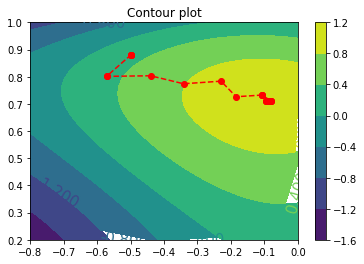

In [1]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt

def black_box_function(x1, x2):
  return -((4-2.1*x1**2+((x1**4)/3))*x1**2+x1*x2+(-4+4*(x2**2))*(x2**2))
x1 = np.linspace(-0.8, 0, 500)
x2 = np.linspace(0.2, 1, 500)
x1, x2 = np.meshgrid(x1, x2)
Z = black_box_function(x1, x2)
fig = plt.figure()
plt.title('Contour plot')
contours=plt.contourf(x1, x2, Z,cmap='viridis')
plt.clabel(contours, inline=True, fontsize=15)
plt.colorbar()

optimizer = BayesianOptimization(
    f=None,
    pbounds={'x1': (-3, 3), 'x2': (-2, 2)},
    verbose=2,
    random_state=1,
)
from bayes_opt import UtilityFunction

utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)
next_point_to_probe = optimizer.suggest(utility)
#print("Next point to probe is:", next_point_to_probe)
target = black_box_function(**next_point_to_probe)
#print("Found the target value to be:", target)
optimizer.register(
    params=next_point_to_probe,
    target=target,
)
iterat=50
i=0
datax1=np.zeros(iterat)
datax2=np.zeros(iterat)
for i in range(iterat):
    next_point = optimizer.suggest(utility)
    target = black_box_function(**next_point)
    optimizer.register(params=next_point, target=target)
    print(target, next_point)
    datax1[i]=(optimizer.max['params']['x1'])
    datax2[i]=(optimizer.max['params']['x2'])
    i+=1
plt.plot(datax1,datax2,'ro--')
print('mimimmum value:',-optimizer.max['target'],'x1:',optimizer.max['params']['x1'],'x2:',optimizer.max['params']['x2'])